## Importing necessary packages

In [8]:
# pip install ... in your terminal! 
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize , poly)
import matplotlib.pyplot as plt

## Simple Linear Regression

### Basic Introduction on fitting the model

There is a simple loading function `load_data` in ISLP package:

In [9]:
# Load the Boston housing data
Boston = load_data('Boston')

In [10]:
# Inspect the data
print(Boston.columns)

# Type Boston? to find out more about these data. 
# you can use command + / to quickly comment/uncomment a line of code:

# Boston?

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat', 'medv'],
      dtype='object')


We know the following:
1. `medv` is median value of owner-occupied homes in thousands
2. `lstat` is lower status of the population

we can fit a model with `medv` as response variable and `lstat` as independent variable

In [12]:
# For this model, we can create the model matrix by hand.
# Define the model specification
X = pd.DataFrame({'intercept': np.ones(Boston.shape[0]),
'lstat': Boston['lstat']})
# and displays the first 4 rows
X[:4]


intercept  lstat
0        1.0   4.98
1        1.0   9.14
2        1.0   4.03
3        1.0   2.94

In [13]:
# extract the response and fit the model:
y = Boston['medv']
model = sm.OLS(y, X)
results = model.fit()

In [17]:
# looking into the summary:
summarize(results)

coef  std err       t  P>|t|
intercept  34.5538    0.563  61.415    0.0
lstat      -0.9500    0.039 -24.528    0.0

note that the `summarize` function shows a quick summary of information using built-in function from ISLP package, for a more detailed summary, people could use `summary()` function in python:

In [7]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Fri, 06 Sep 2024   Prob (F-statistic):           5.08e-88
Time:                        15:02:56   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     34.5538      0.563     61.415      0.000      33.448      35.659
lstat         -0.9500      0.039    -24.528      0.000      -1.026      -0.874
==============================================================================
Omnibus:                      137.043   Durbin-Watson:                   0.892
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              291.373
Skew:                           1.453   Prob(JB):                     5.36e-64
Kurtosis:                       5.319   Cond. No.                         29.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Alternatively, we could use built-in functions `fit` and `transform` to fit the model  and transform X:

In [8]:
design = MS(['lstat'])
design = design.fit(Boston)
X = design.transform(Boston)
X[:4]

intercept  lstat
0        1.0   4.98
1        1.0   9.14
2        1.0   4.03
3        1.0   2.94

we could also merge the `design.fit` and `transform` into one step:

In [9]:
design = MS(['lstat'])
X = design.fit_transform(Boston)
X[:4]

intercept  lstat
0        1.0   4.98
1        1.0   9.14
2        1.0   4.03
3        1.0   2.94

The fitted coefficients can also be retrieved as the `params` attribute of
results:

In [10]:
results.params

intercept    34.553841
lstat        -0.950049
dtype: float64

### Predictions using the fitted model

The `get_prediction()` method can be used to obtain predictions, and produce confidence intervals and prediction intervals for the prediction of medv for given values of lstat.

We first create a new data frame, in this case containing only the variable
`lstat`, with the values for this variable at which we wish to make
predictions. We then use the `transform()` method of design to create the
corresponding model matrix.

In [11]:
# for example for 3 values of lstat = 5, 10, 15
new_df = pd.DataFrame({'lstat':[5, 10, 15]})
newX = design.transform(new_df)
newX

intercept  lstat
0        1.0      5
1        1.0     10
2        1.0     15

Next we compute the predictions at `newX`, and view them by extracting
the predicted_mean attribute.

In [12]:
new_predictions = results.get_prediction(newX)
new_predictions.predicted_mean

array([29.80359411, 25.05334734, 20.30310057])

We can produce confidence intervals for the predicted values.

In [13]:
new_predictions.conf_int(alpha=0.05)

array([[29.00741194, 30.59977628],
       [24.47413202, 25.63256267],
       [19.73158815, 20.87461299]])

Prediction intervals are computing by setting `obs=True`:

In [14]:
new_predictions.conf_int(obs=True , alpha=0.05)

array([[17.56567478, 42.04151344],
       [12.82762635, 37.27906833],
       [ 8.0777421 , 32.52845905]])

For instance, the 95% confidence interval associated with an lstat value of
10 is (24.47, 25.63), and the 95% prediction interval is (12.82, 37.28). As
expected, the confidence and prediction intervals are centered around the
same point (a predicted value of 25.05 for medv when lstat equals 10), but
the latter are substantially wider.

### Plotting the data and the model

We will now plot `medv` and `lstat` using `DataFrame.plot.scatter()`, and add the regression line to the resulting plot, we will first define a function `abline` that adds a linear regression fitted model to graphs:

In [15]:
def abline(ax, b, m, *args , **kwargs):
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim , ylim , *args , **kwargs)

The function has arguments `ax`, `b`, `m` where
`ax` is an axis object for an exisiting plot, `b` is the intercept and `m` is the slope of the desired line. The addition of `*args` allows any number of non-named arguments to abline, while `*kwargs` allows any number of named arguments (such as
linewidth=3) to abline.

we can now plot the graph as:

/var/folders/0h/0qf279212tbbfjv71z01qdkc0000gn/T/ipykernel_49203/2616703611.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[0],
/var/folders/0h/0qf279212tbbfjv71z01qdkc0000gn/T/ipykernel_49203/2616703611.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[1],


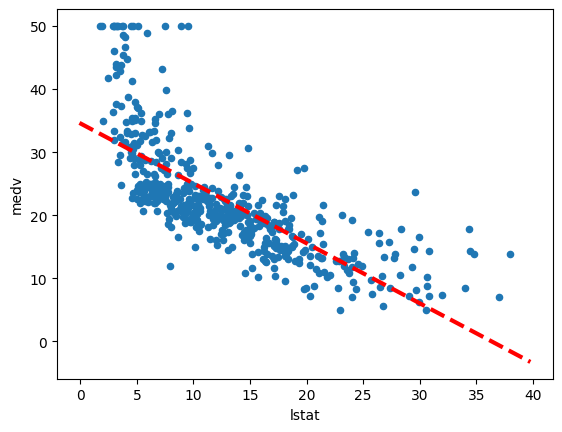

In [16]:
ax = Boston.plot.scatter('lstat', 'medv')
abline(ax,
results.params[0],
results.params[1],
'r--',
linewidth=3)

We could also perform some diagnosis on the fitted model by plotting the residuals:

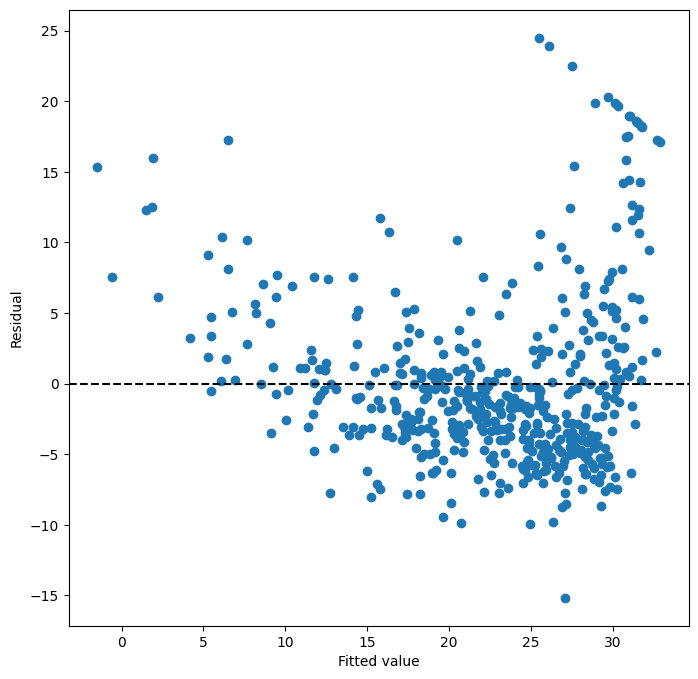

In [17]:
ax = subplots(figsize=(8,8))[1]
ax.scatter(results.fittedvalues , results.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--');

On the basis of the residual plot (not shown), there is some evidence
of non-linearity.

## Multi-variate Linear Regression

If we want to fit a model on `medv` using both `age` and `lstat`:

In [18]:
X = MS(['lstat', 'age']).fit_transform(Boston)
model1 = sm.OLS(y, X)
results1 = model1.fit()
summarize(results1)

coef  std err       t  P>|t|
intercept  33.2228    0.731  45.458  0.000
lstat      -1.0321    0.048 -21.416  0.000
age         0.0345    0.012   2.826  0.005

If we want to fit a model on `medv` using all the variables:

In [19]:
terms = Boston.columns.drop('medv')
terms

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat'],
      dtype='object')

In [20]:
X = MS(terms).fit_transform(Boston)
model = sm.OLS(y, X)
results = model.fit()
summarize(results)

coef  std err       t  P>|t|
intercept  41.6173    4.936   8.431  0.000
crim       -0.1214    0.033  -3.678  0.000
zn          0.0470    0.014   3.384  0.001
indus       0.0135    0.062   0.217  0.829
chas        2.8400    0.870   3.264  0.001
nox       -18.7580    3.851  -4.870  0.000
rm          3.6581    0.420   8.705  0.000
age         0.0036    0.013   0.271  0.787
dis        -1.4908    0.202  -7.394  0.000
rad         0.2894    0.067   4.325  0.000
tax        -0.0127    0.004  -3.337  0.001
ptratio    -0.9375    0.132  -7.091  0.000
lstat      -0.5520    0.051 -10.897  0.000

if we want to fit a model on `medv` on all variables but `age`:

In [21]:
minus_age = Boston.columns.drop(['medv', 'age'])
Xma = MS(minus_age).fit_transform(Boston)
model1 = sm.OLS(y, Xma)
summarize(model1.fit())

coef  std err       t  P>|t|
intercept  41.5251    4.920   8.441  0.000
crim       -0.1214    0.033  -3.683  0.000
zn          0.0465    0.014   3.379  0.001
indus       0.0135    0.062   0.217  0.829
chas        2.8528    0.868   3.287  0.001
nox       -18.4851    3.714  -4.978  0.000
rm          3.6811    0.411   8.951  0.000
dis        -1.5068    0.193  -7.825  0.000
rad         0.2879    0.067   4.322  0.000
tax        -0.0127    0.004  -3.333  0.001
ptratio    -0.9346    0.132  -7.099  0.000
lstat      -0.5474    0.048 -11.483  0.000

### Add in interaction terms to the equation

Please also review the interpretation of coefficients when using interaction terms

In [22]:
X = MS(['lstat',
'age',
('lstat', 'age')]).fit_transform(Boston)
model2 = sm.OLS(y, X)
summarize(model2.fit())

coef  std err       t  P>|t|
intercept  36.0885    1.470  24.553  0.000
lstat      -1.3921    0.167  -8.313  0.000
age        -0.0007    0.020  -0.036  0.971
lstat:age   0.0042    0.002   2.244  0.025

### Qualitative Predictors:

Here we use the `Carseats` data, which is included in the ISLP package. We
will attempt to predict Sales (child car seat sales) in 400 locations based
on a number of predictors.

In [23]:
Carseats = load_data('Carseats')
Carseats.columns

Index(['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price',
       'ShelveLoc', 'Age', 'Education', 'Urban', 'US'],
      dtype='object')

The predictor `ShelveLoc` takes on three possible values, `Bad`, `Medium`, and `Good`. Given a qualitative variable such as ShelveLoc, `ModelSpec()` generates dummy variables automatically.

In [24]:
allvars = list(Carseats.columns.drop('Sales'))
y = Carseats['Sales']

# adding in some interaction effect
final = allvars + [('Income', 'Advertising'), 
('Price', 'Age')]
X = MS(final).fit_transform(Carseats)
model = sm.OLS(y, X)
summarize(model.fit())

coef  std err       t  P>|t|
intercept           6.5756    1.009   6.519  0.000
CompPrice           0.0929    0.004  22.567  0.000
Income              0.0109    0.003   4.183  0.000
Advertising         0.0702    0.023   3.107  0.002
Population          0.0002    0.000   0.433  0.665
Price              -0.1008    0.007 -13.549  0.000
ShelveLoc[Good]     4.8487    0.153  31.724  0.000
ShelveLoc[Medium]   1.9533    0.126  15.531  0.000
Age                -0.0579    0.016  -3.633  0.000
Education          -0.0209    0.020  -1.063  0.288
Urban[Yes]          0.1402    0.112   1.247  0.213
US[Yes]            -0.1576    0.149  -1.058  0.291
Income:Advertising  0.0008    0.000   2.698  0.007
Price:Age           0.0001    0.000   0.801  0.424

*Quick explanation of the above results:*

In the first line above, we made allvars a list, so that we could add the
interaction terms two lines down. Our model-matrix builder has created a
`ShelveLoc[Good]` dummy variable that takes on a value of 1 if the shelving
location is good, and 0 otherwise. It has also created a `ShelveLoc[Medium]`
dummy variable that equals 1 if the shelving location is medium, and 0 otherwise.
A bad shelving location corresponds to a zero for each of the two
dummy variables. The fact that the coefficient for `ShelveLoc[Good]` in the
regression output is positive indicates that a good shelving location is associated
with high sales (relative to a bad location). And `ShelveLoc[Medium]`
has a smaller positive coefficient, indicating that a medium shelving location
leads to higher sales than a bad shelving location, but lower sales than
a good shelving location.